# PyGAM tutorial
### phil
following: https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f; 
with some efficiency modifications

##### preliminaries

In [98]:
import numpy as np
import pandas as pd
from pygam import LogisticGAM, LinearGAM
import pygam
from sklearn.datasets import load_breast_cancer, load_boston
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

%matplotlib inline

##### data description

In [15]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df = df[['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness']]
target_df = pd.Series(data.target)
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400


In [17]:
target_df.describe()

count    569.000000
mean       0.627417
std        0.483918
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64

In [21]:
gam = LogisticGAM().fit(df, target_df)

C:\Users\Philip\Anaconda2\lib\site-packages\pygam\utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
C:\Users\Philip\Anaconda2\lib\site-packages\pygam\distributions.py:223: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y * (1 - (mu / n))**(n - y))


In [22]:
gam.summary()

Model Statistics
-------------------------
edof               22.822
AIC               145.995
AICc              148.168
UBRE                2.289
loglikelihood     -50.175
deviance           100.35
scale                 1.0

Pseudo-R^2
----------------------------
explained_deviance     0.866
McFadden               0.866
McFadden_adj           0.806


In [23]:
gam.accuracy(df, target_df)

0.961335676625659

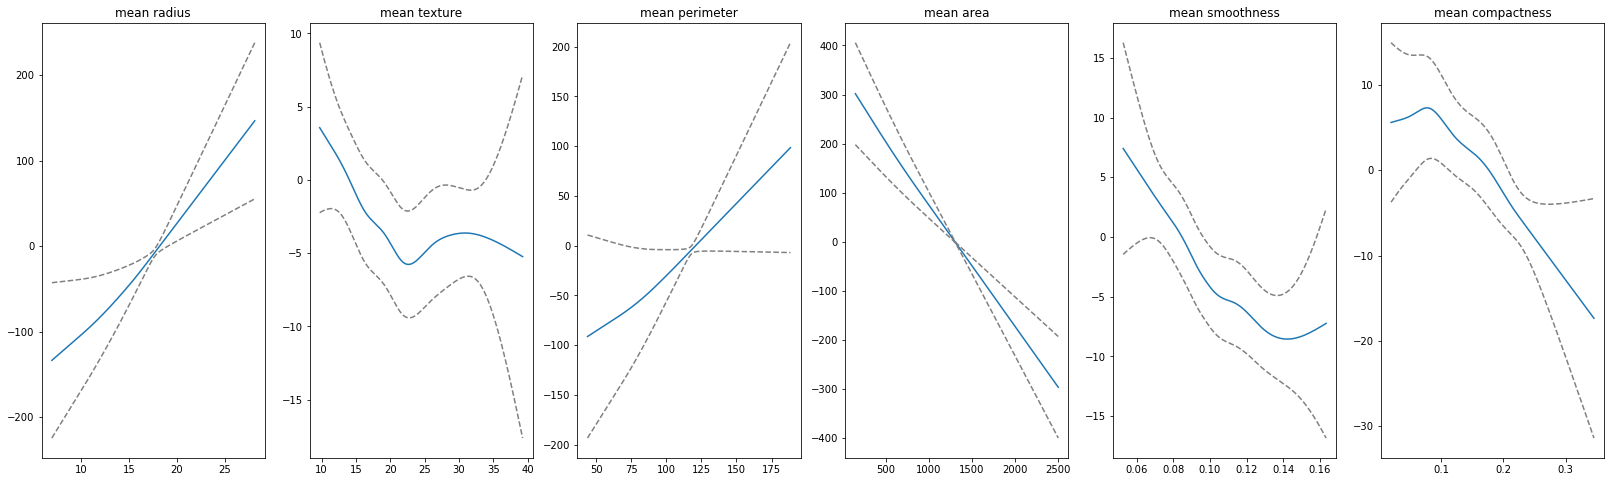

In [54]:
XX = pygam.utils.generate_X_grid(gam)
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(data.feature_names[0:6]))
titles = data.feature_names
for i, ax in enumerate(axs):
    pdep, confi = gam.partial_dependence(XX, feature=i+1, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[0][:,0], c='grey', ls='--')
    ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
    ax.set_title(titles[i])
    


## Toggle some of the smoothing parameters

In [57]:
lambda_=0.6
n_splines=[25, 6, 25, 25, 6, 4]
constraints=None
gam = LogisticGAM(constraints=constraints, lam=lambda_, n_splines=n_splines).fit(df, target_df)

In [61]:
print(gam.summary())
print(gam.accuracy(df, target_df))

Model Statistics
-------------------------
edof               11.076
AIC               152.157
AICc              152.725
UBRE                2.283
loglikelihood     -65.003
deviance          130.005
scale                 1.0

Pseudo-R^2
----------------------------
explained_deviance     0.827
McFadden               0.827
McFadden_adj           0.798
None
0.95079086116


In [65]:
def pdp_plotter(gam_obj, dset):
    """Function to construct all partial dependence plots for a particular graph
    
    Args:
        gam_obj: pygam model object of fixed or custom specification
        dset: sklearn bunch data set
    Returns:
        plots with number of features 
    """
    XX = pygam.utils.generate_X_grid(gam_obj)
    plt.rcParams['figure.figsize'] = (28, 8)
    fig, axs = plt.subplots(1, len(dset.feature_names[0:6]))
    titles = dset.feature_names
    for i, ax in enumerate(axs):
        pdep, confi = gam_obj.partial_dependence(XX, feature=i+1, width=.95)
        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi[0][:,0], c='grey', ls='--')
        ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
        ax.set_title(titles[i])    

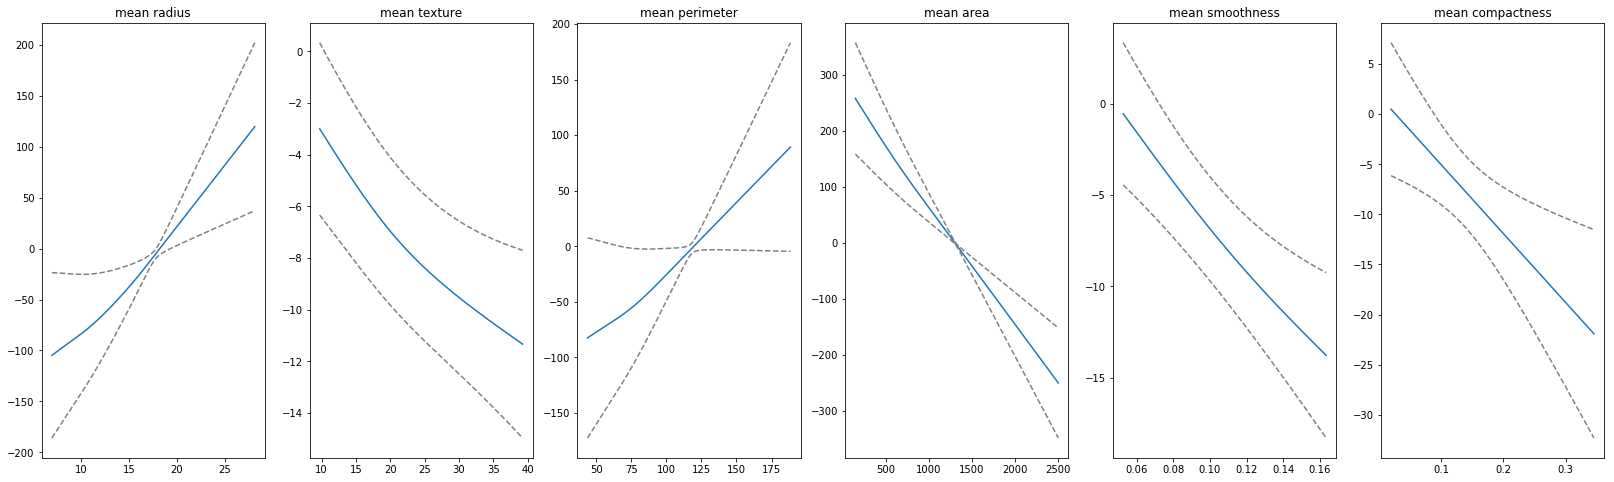

In [66]:
pdp_plotter(gam_obj=gam, dset=data)

##### gridsearch

In [71]:
gam = LogisticGAM().gridsearch(df, target_df, keep_best=True)

100% (11 of 11) |#########################| Elapsed Time: 0:00:02 Time: 0:00:02


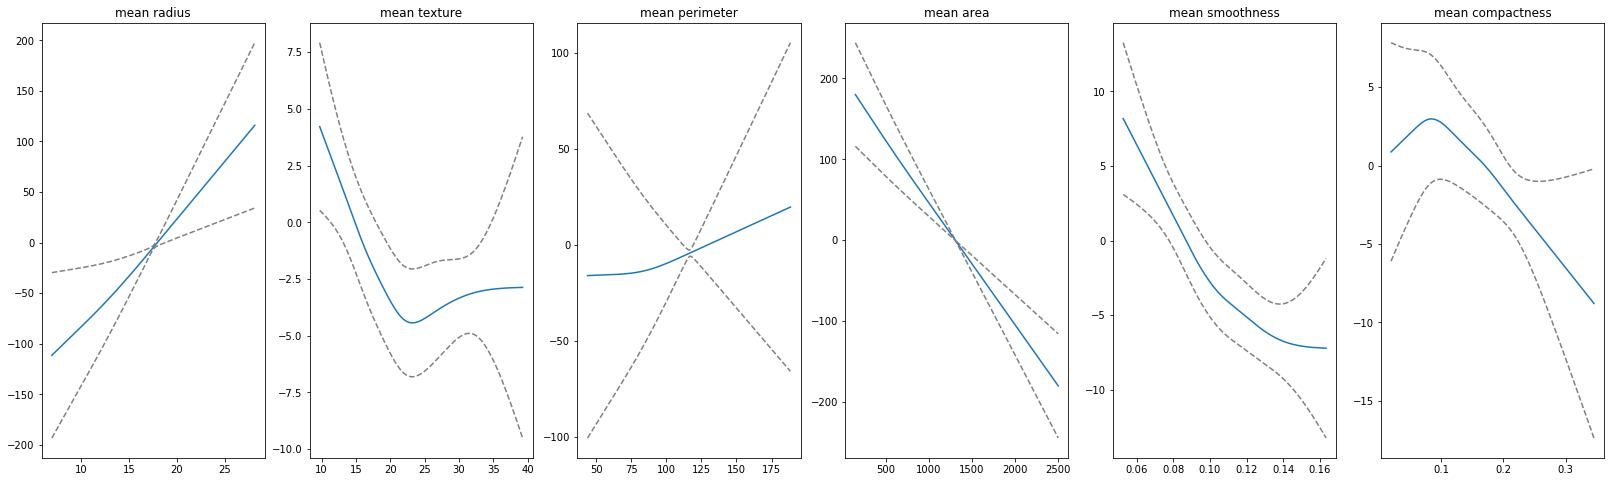

In [75]:
gam.accuracy(df, target_df)
pdp_plotter(gam_obj=gam, dset=data)

### GAM cross-validation

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df, target_df, test_size=0.33, random_state=42)
gam = LogisticGAM().gridsearch(X_train, y_train)

100% (11 of 11) |#########################| Elapsed Time: 0:00:02 Time: 0:00:02


In [85]:
predictions = gam.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, predictions)))
probas = gam.predict_proba(X_test)
print("Log Loss: {}".format(log_loss(y_test, probas)))

Accuracy: 0.957446808511
Log Loss: 0.126179009744


In [92]:
lambda_ = [0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
n_splines = [4, 14, 4, 6, 12, 12] 
constraints = [None, None, None, None, None, None]
X_train, X_test, y_train, y_test = train_test_split(df, target_df, test_size=0.33, random_state=42)
gam = LogisticGAM(constraints=constraints, 
                  lam=lambda_,
                 n_splines=n_splines).fit(X_train, y_train)
predictions = gam.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, predictions)))
probas = gam.predict_proba(X_test)
print("Log Loss: {}".format(log_loss(y_test, probas)))

Accuracy: 0.968085106383
Log Loss: 0.107076731405


### Regression

In [97]:
boston = load_boston()

df = pd.DataFrame(boston.data, columns=boston.feature_names)
target_df = pd.Series(boston.target)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [99]:
gam = LinearGAM(n_splines=10).gridsearch(df, target_df)

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\Philip\Anaconda2\lib\site-packages\pygam\pygam.py:1172: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
100% (11 of 11) |#########################| Elapsed Time: 0:00:01 Time: 0:00:01


In [100]:
gam.summary()

Model Statistics
---------------------------
edof                 83.363
AIC                2687.268
AICc               2721.509
GCV                  14.135
loglikelihood     -1259.271
deviance            422.637
scale                10.016

Pseudo-R^2
----------------------------
explained_deviance     0.901
McFadden               0.604
McFadden_adj           0.578


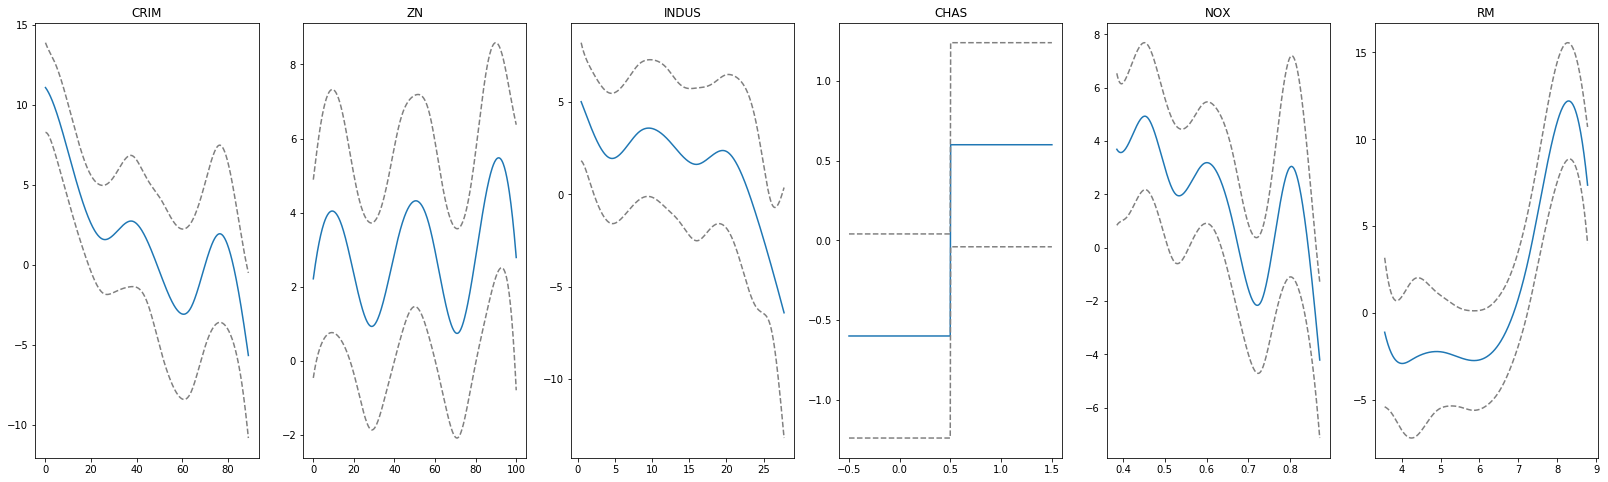

In [105]:
pdp_plotter(gam_obj=gam, dset=boston)